# Project Zillow

* Predict the tax assessed property value of Zillow Single Family Residential properties with transaction date in 2017

## Goal

* Discover drivers of property value
* Use drivers to develop a machine learning model to predict property value

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PolynomialFeatures
# local
import wrangle as w
import explore as e
import modeling as m

## Acquire

* Data acquired from Codeup MySQL DB
* Data initially acquired on 15 May 2023
* It contained 52,441 rows and 62 columns before cleaning
* Each row represents a unique parcel for each transaction it had in 2017
* Each column represents an element of the parcel

## Prepare

**Prepare Actions**:

* Replaced null values with appropriate values if logical
    - 0 for most columns
    - lotsize = area if lotsize value is missing
* Split transaction date to month and day since all are 2017
* Renamed columns to promote readability
* Removed columns that did not contain useful information
    - too many null values that couldn't be logically imputed
    - related to target (property value)
    - duplicated information
* Removed rows
    - nulls that couldn't logically be imputed
    - duplicate parcels, kept most recent transaction date
* Checked that column data types were appropriate
* Handled outliers
    - property value < 98th quantile
    - area < 6000
* Mapped FIPS code to county
* Encoded categorical variables
    - created dummy variables for categorical variables
* Split data into train, validate and test (approx. 60/20/20)
* Scaled using Standard Scaler for modeling

In [2]:
# acquire, clean, and prepare the data
df = w.wrangle_zillow_mvp()

# split into train, validate, and test datasets
train, validate, test = w.split_data(df)

#### A brief look at the data

In [3]:
train.head()

,beds,baths,area,prop_value,rooms
9568,3,2.0,1001,265150,5.0
18363,3,2.0,1580,1275356,5.0
2877,3,2.0,1128,498221,5.0
30380,4,2.0,1188,105337,6.0
2657,3,2.0,1470,399808,5.0


## Explore

* Is there a correlation between area and property value?
* Is there a correlation between beds and property value?
* Is there a correlation between baths and property value?
* Is there a correlation between rooms and property value?

### 1) Is there a correlation between area and property value?
* $H_0$: There is **NO** correlation between area and property value
* $H_a$: There is a correlation between area and property value
* Continuous (area) vs Continuous (prop_value) = $Spearman's R$
    - $r$ = 0.5017813399669965
    - $p$ = 0.0
* `Area` is correlated with `property value`

Spearman's R: area and prop_value
 r = 0.5017813399669965, p = 0.0


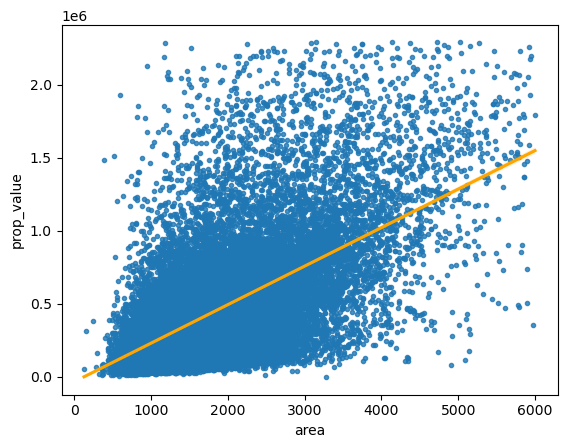

In [4]:
# explore area and property value
e.pear(train,'area','prop_value')
sns.regplot(data=train,x='area',y='prop_value',marker='.',line_kws={'color':'orange'})
plt.show()

**With an alpha of 0.05 (confidence 95%) the p-value is less than alpha. Therefore, evidence suggests that area and property value are correlated with each other. I believe that using `area` in the modeling will have a positive impact.**

### 2) Is there a correlation between beds and property value?
* $H_0$: There is **NO** correlation between beds and property value
* $H_a$: There is a correlation between beds and property value
* Continuous (beds) vs Continuous (prop_value) = $Spearman's R$
    - $r$ = 0.2779446490732613
    - $p$ = 0.0
* `Beds` is correlated with `property value`

Spearman's R: beds and prop_value
 r = 0.2779446490732613, p = 0.0


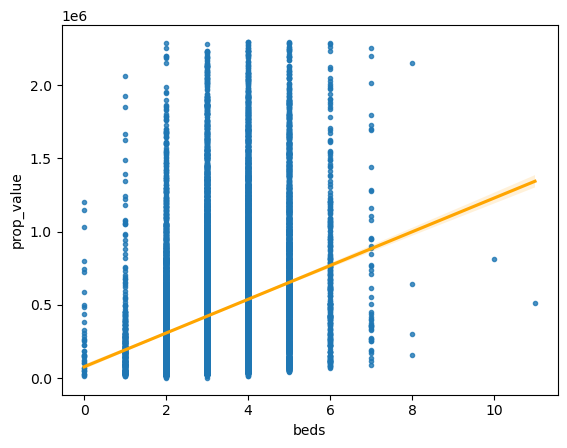

In [5]:
# explore beds and property value
e.pear(train,'beds','prop_value')
sns.regplot(data=train,x='beds',y='prop_value',marker='.',line_kws={'color':'orange'})
plt.show()

**With an alpha of 0.05 (confidence 95%) the p-value is less than alpha. Therefore, evidence suggests that beds and property value are correlated with each other. I believe that using `beds` in the modeling will have a positive impact.**

### 3) Is there a correlation between baths and property value?
* $H_0$: There is **NO** correlation between baths and property value
* $H_a$: There is a correlation between baths and property value
* Continuous (baths) vs Continuous (prop_value) = $Spearman's R$
    - $r$ = 0.4600307927313944 
    - $p$ = 0.0
* `Baths` is correlated with `property value`

Spearman's R: baths and prop_value
 r = 0.4600307927313944, p = 0.0


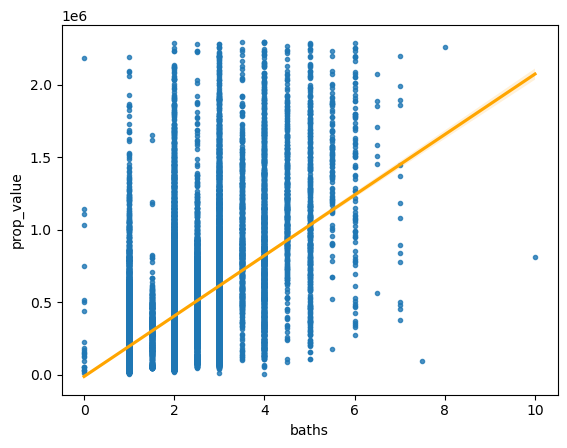

In [6]:
# explore baths and property value
e.pear(train,'baths','prop_value')
sns.regplot(data=train,x='baths',y='prop_value',marker='.',line_kws={'color':'orange'})
plt.show()

**With an alpha of 0.05 (confidence 95%) the p-value is less than alpha. Therefore, evidence suggests that baths and property value are correlated with each other. I believe that using `baths` in the modeling will have a positive impact.**

### 4) Is there a correlation between rooms and property value?
* $H_0$: There is **NO** correlation between rooms and property value
* $H_a$: There is a correlation between rooms and property value
* Continuous (rooms) vs Continuous (prop_value) = $Spearman's R$
    - $r$ = 0.40240576705209985
    - $p$ = 0.0
* `Rooms` is correlated with `property value`

Spearman's R: rooms and prop_value
 r = 0.40240576705209985, p = 0.0


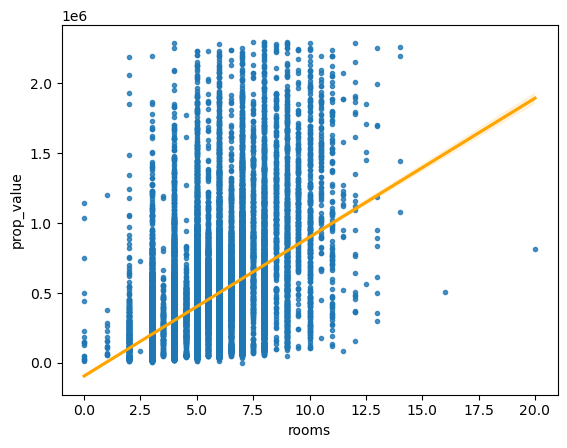

In [7]:
# explore baths and area
e.pear(train,'rooms','prop_value')
sns.regplot(data=train,x='rooms',y='prop_value',marker='.',line_kws={'color':'orange'})
plt.show()

**With an alpha of 0.05 (confidence 95%) the p-value is less than alpha. Therefore, evidence suggests that rooms and prop_value are correlated with each other. I believe that using `rooms` in the modeling will have a positive impact.**

## Exploration Summary
* Area, beds, baths, and rooms are all correlated with property value

### Features for modeling
* Features that will be used:
    - property value (target)
* Some features that may be useful:
    - area
    - baths
    - beds
    - rooms

## Modeling

* $RMSE$ and $R^2$ will be the evaluation metrics
* Target feature is property value
* Using the mean of property values as the baseline
    - 454401.68 will be the baseline property value
* Features scaled using Standard Scaler
* Models will be developed and evaluated using a few different model types, various features, and various hyperparameter configurations
    - Linear Regression
    - Polynomial Features through Linear Regression
    - Lasso Lars
    - Tweedie Regression
* Models will be evaluated on train and validate datasets
* Best performing model will be the only one evaluated on the test dataset

In [8]:
# split into X and y
X_train,X_val,X_test = train.drop(columns=['prop_value']),validate.drop(columns=['prop_value']),test.drop(columns=['prop_value'])
y_train,y_val,y_test = train[['prop_value']],validate[['prop_value']],test[['prop_value']]

# Standard Scaler
Xs_train,Xs_val,Xs_test = w.std_zillow(X_train,X_val,X_test)

In [9]:
# get baseline accuracy
m.baseline(y_train,y_val)

Baseline Property Value: 454401.68
Train       RMSE: 376239.8580678781   R2: 0.0
Validate    RMSE: 374507.60109540797    R2: -1.3876480933205926e-06


### Best of 4 Model Configurations

#### Linear Regression

In [10]:
# get linear regression results
m.mvp_model('lr',Xs_train,y_train,Xs_val,y_val)

Linear Regression
Train       RMSE: 300624.8128675796   R2: 0.3615600675886367
Validate    RMSE: 303067.64775916864    R2: 0.3451248879233514


#### Polynomial Features through Linear Regression

In [11]:
# get polynomial feature results
m.mvp_model('poly',Xs_train,y_train,Xs_val,y_val)

Polynomial Features through Linear Regression
Train       RMSE: 299406.80470749474   R2: 0.36672297966822553
Validate    RMSE: 302220.2037655362    R2: 0.3487821180841185


#### Lasso Lars

In [12]:
# get lasso lars results
m.mvp_model('lasso',Xs_train,y_train,Xs_val,y_val)

Lasso Lars
Train       RMSE: 300624.45985419984   R2: 0.36156156698387154
Validate    RMSE: 303067.55446600285    R2: 0.34512529110306034


#### Tweedie Regression

In [13]:
# get tweedie regression results
m.mvp_model('tweedie',Xs_train,y_train,Xs_val,y_val)

Tweedie Regressor
Train       RMSE: 305363.6810119224   R2: 0.3412734613689392
Validate    RMSE: 309029.7371037776    R2: 0.31910542468414294


### Best on Test
* Polynomial Features

In [14]:
# get test results for final model
m.test_mvp_model(Xs_train,y_train,Xs_test,y_test)

Polynomial Features through Linear Regression
Test    RMSE: 302362.0958800834    R2: 0.35785015991275215


### Modeling Wrap Up
* Linear Regression and Lasso Lars had similar RMSE and R2 for train and validate, RMSE about 300k (train) and 303k (validate) and R2 about 0.362 (train) and 0.345 (validate)
* Tweedie Regressor had the worst performance among the models with RMSE at about 305k (train) and 309k (validate), R2 also lagged behind at 0.341 (train) and 0.319 (validate)
* Polynomial Features had the best performance for train and validate, RMSE was the smallest 299k (train) and 302k (validate) and R2 was the biggest (0.367 and 0.349)
* With the test done on Polynomial Features, we get RMSE 302k and R2 0.358

## Conclusion

### Takeaways and Key Findings
* There is a correlation between each feature (area, beds, baths, and rooms) with property value
* Area seemed to be the most correlated feature and models worked best with it included

### Recommendations
* Make sure that area is included and accurate when a property is added for best predictions

### Next Steps
* Given more time I could check other features such as location to hopefully get more insights and build a better model